In [149]:
import pandas as pd
import os
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from screeninfo import get_monitors
#04_analysis_osm_presence_igm_declaration.py

In [150]:
data = pd.read_parquet("data" + os.sep + "data_igm_proveniance_osm_provincies.parquet")
data.rename(columns={'objects':'total_objects'},inplace=True)
# Raggruppiamo per regione e calcoliamo le percentuali
data_italy = data.groupby(['name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()
data_region = data.groupby(['region','name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()
data_provincies = data.groupby(['province','name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()

In [151]:
regions_label = ""
for r in data_region.region.unique():
    regions_label += r + " "


In [152]:
regions_label

'Abruzzo Basilicata Calabria Campania Lazio Marche Molise Puglia Sicilia Toscana '

In [153]:
data_italy['percentage'] = round(data_italy['osm_objects'] / data_italy['total_objects'] * 100,3)
data_italy_with_osm = data_italy[data_italy.percentage >= 1]
data_italy_with_osm['missing'] = 100 - data_italy_with_osm['percentage']
data_italy_with_osm = data_italy_with_osm.sort_values(by='percentage', ascending=False)

/tmp/ipykernel_18561/4004942816.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



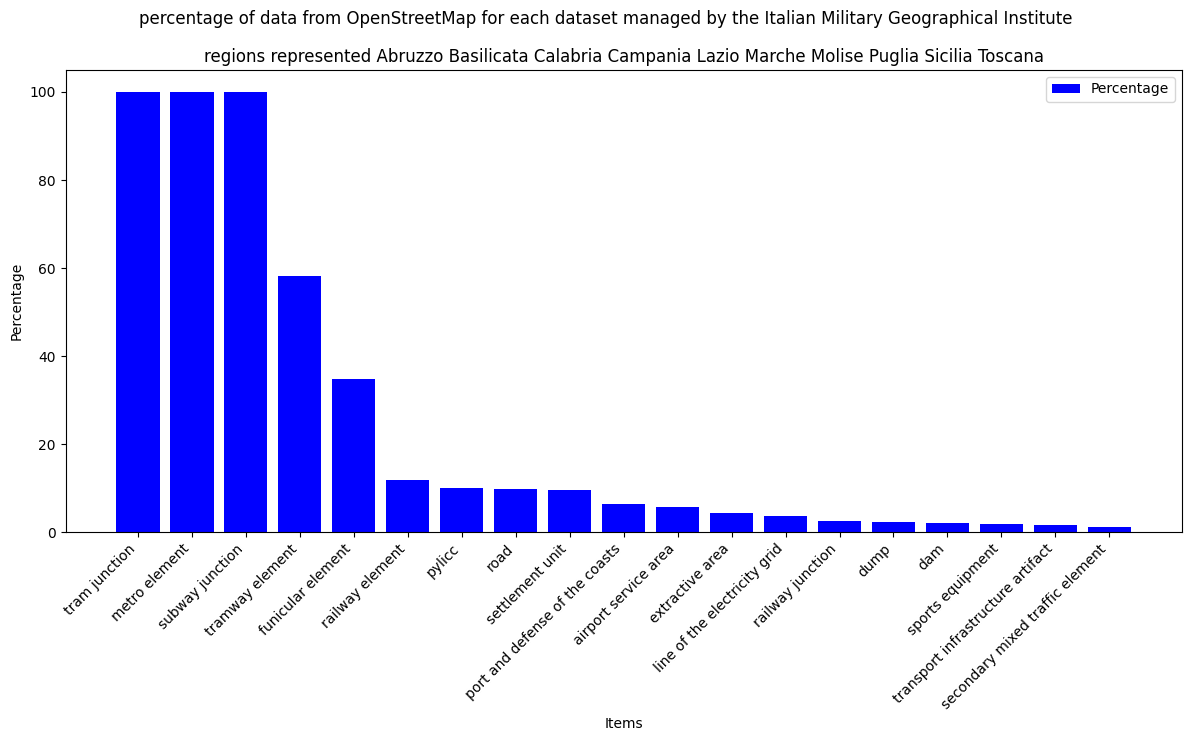

In [154]:
monitor_width = int(get_monitors()[0].width)
fig, ax = plt.subplots(figsize=(monitor_width/100, 6))
plt.bar(data_italy_with_osm['name_en'], data_italy_with_osm['percentage'], color='b', label='Percentage')
#plt.bar(data_italy_with_osm['name_en'], data_italy_with_osm['missing'], bottom=data_italy_with_osm['percentage'], color='g', label='Missing')
plt.xlabel('Items')
plt.ylabel('Percentage')
ax.set_xticklabels(data_italy_with_osm['name_en'], rotation=45, ha='right')
plt.legend()
plt.suptitle("percentage of data from OpenStreetMap for each dataset managed by the Italian Military Geographical Institute")
plt.title("regions represented " + regions_label.rstrip())
plt.show()

In [155]:
data_regione_with_osm_data = data_region[data_region.osm_objects > 0]
data_regione_with_osm_data['percentage'] = round(data_regione_with_osm_data['osm_objects'] / data_regione_with_osm_data['total_objects'] * 100,3)
data_regione_with_osm_data[data_regione_with_osm_data.percentage >= 1]

,region,name_it,name_en,layer_name,osm_objects,total_objects,percentage
6,Abruzzo,area a servizio del trasporto su ferro,area of ​​transport on iron transport,sv_fer,1,81,1.235
51,Abruzzo,manufatto d'infrastruttura di trasporto,transport infrastructure artifact,man_tr,6,76,7.895
59,Abruzzo,opera portuale e di difesa delle coste,port and defense of the coasts,op_por,29,579,5.009
73,Abruzzo,unità insediativa,settlement unit,pe_uins,32,1328,2.410
144,Basilicata,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,20,1551,1.289
...,...,...,...,...,...,...,...
704,Toscana,elemento di viabilità mista secondaria,secondary mixed traffic element,el_vms,21900,310401,7.055
708,Toscana,elemento tramviario,tramway element,el_trv,41,41,100.000
736,Toscana,sostegno a traliccio,pylicc,tralic,1870,22652,8.255
741,Toscana,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,4664,4685,99.552


In [156]:
data_provincies_with_osm_data = data_provincies[data_provincies.osm_objects > 0]
data_provincies_with_osm_data['percentage'] = round(data_provincies_with_osm_data['osm_objects'] / data_provincies_with_osm_data['total_objects'] * 100,3)
data_provincies_with_osm_data = data_provincies_with_osm_data[data_provincies.osm_objects > 0]

/tmp/ipykernel_18561/1859529673.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [157]:
#data_provincies_with_osm_data[data_provincies_with_osm_data['province'] == 'Ragusa'].sort_values(by="percentage", ascending=False)

In [158]:
#data_regione_with_osm_data[data_regione_with_osm_data['region'] == 'Sicilia'].sort_values(by="percentage", ascending=False)

In [159]:
#data_regione_with_osm_data.region.unique()

In [160]:
data_italy

,name_it,name_en,layer_name,osm_objects,total_objects,percentage
0,acqua interna,internal water,acq_in,0,2892,0.000
1,acqua territoriale,territorial water,acq_ter,0,24,0.000
2,affioramento naturale dell'acqua,natural outcrop of water,af_acq,0,6525,0.000
3,alveo,riverbed,alveo,0,4162,0.000
4,ambito omogeneo per la metainformazione,homogeneous scope for metainformation,meta,0,6513,0.000
...,...,...,...,...,...,...
71,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,5062,143165,3.536
72,tratto stradale,road,tr_str,206885,2110013,9.805
73,unità insediativa,settlement unit,pe_uins,2725,28325,9.620
74,vertice di rete,network vertex,v_rete,0,12560,0.000


In [161]:
data_italy[data_italy.percentage >= 1].sort_values(by="percentage", ascending=False)

,name_it,name_en,layer_name,osm_objects,total_objects,percentage
44,giunzione tranviaria,tram junction,gz_trv,2,2,100.000
31,elemento di metropolitana,metro element,el_met,219,219,100.000
41,giunzione di metropolitana,subway junction,gz_met,28,28,100.000
38,elemento tramviario,tramway element,el_trv,152,261,58.238
36,elemento funicolare,funicular element,el_fun,17,49,34.694
35,elemento ferroviario,railway element,el_fer,5959,50517,11.796
66,sostegno a traliccio,pylicc,tralic,19599,195048,10.048
72,tratto stradale,road,tr_str,206885,2110013,9.805
73,unità insediativa,settlement unit,pe_uins,2725,28325,9.620
59,opera portuale e di difesa delle coste,port and defense of the coasts,op_por,335,5220,6.418
